In [58]:
import pandas as pd
import numpy as np

df = pd.read_csv('poetry.csv')
df = df.drop(columns=df.columns[[5, 6, 7, 8]], axis=1)

df = df[:1024]

def get_century_roman(year):
	century = year // 100 + 1
	roman_numerals = {
		1: 'I', 2: 'II', 3: 'III', 4: 'IV', 5: 'V',
		6: 'VI', 7: 'VII', 8: 'VIII', 9: 'IX', 10: 'X',
		11: 'XI', 12: 'XII', 13: 'XIII', 14: 'XIV', 15: 'XV',
		16: 'XVI', 17: 'XVII', 18: 'XVIII', 19: 'XIX', 20: 'XX', 21: 'XXI'
	}
	return roman_numerals[century]

def proc_row(row):	
	#text = '\n'.join(row['text'].split('\n')[:4])
	text = row['text'].replace('\r', '')

	line_count = text.count('\n') + 1
	word_count = text.count(' ') + line_count

	name = row['name'] if not pd.isna(row['name']) else row['text'].split('\n')[0]
	author = row['author'] if not pd.isna(row['author']) else 'неизвестен'

	date_from, date_to = row['date_from'], row['date_to']
	date = -1
	if not pd.isna(date_to): date = date_to
	elif not pd.isna(date_from): date = date_from

	century = ''
	epoch = ''
	if date != -1:
		century = f'{get_century_roman(date)} ({int(date//100+1)})'
		if date < 1500: epoch = 'древнерусская поэзия'
		if 1750 <= date < 1850: epoch = 'золотой век'
		if 1850 <= date < 1900: epoch = 'реализм и натурализм восемнадцатого века'
		if 1900 <= date < 1950: epoch = 'серебряный век'
		if 1950 <= date < 1990: epoch = 'советский период'
		if 1990 <= date < 2010: epoch = 'бронзовый век'
		if 2010 <= date < 2100: epoch = 'современная поэзия'


	return pd.Series({'author': author, 'name': name, 'text': text, 
				   	  'date': int(date), 'century': century, 'epoch': epoch, 
				  	  'line_count': line_count, 'word_count': word_count})

df = df.apply(proc_row, axis=1)

df.head()

,author,name,text,date,century,epoch,line_count,word_count
0,Михаил Лермонтов,Забывши волнения жизни мятежной...,"Забывши волнения жизни мятежной,\nОдин жил в п...",1829,XIX (19),золотой век,8,30
1,Сергей Есенин,"Нивы сжаты, рощи голы...","Нивы сжаты, рощи голы,\nОт воды туман и сырост...",1918,XX (20),серебряный век,12,47
2,Игорь Северянин,ЧАРЫ ЛЮЧИНЬ,Лючинь печальная читала вечером ручьисто-вкрад...,1919,XX (20),серебряный век,12,86
3,Анатолий Жигулин,Золото,"Глыбу кварца разбили молотом,\nИ, веселым огне...",1963,XX (20),советский период,30,123
4,Николай Тихонов,Хоровод в Сульдуси,"Хлынул дождь, когда девушки, встав в хоровод,\...",1940,XX (20),серебряный век,16,93


In [31]:
len(df)

16694

In [63]:
from sentence_transformers import SentenceTransformer, util
import torch.nn.functional as F
import math
import torch
from torch import Tensor
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
tqdm.pandas()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#emb_model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
#emb_model = SentenceTransformer('intfloat/multilingual-e5-large')
#emb_model = SentenceTransformer('intfloat/multilingual-e5-small')
#emb_model.to(device)

# tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-base')
# model = AutoModel.from_pretrained('intfloat/multilingual-e5-base')
# tokens_input_size = 512

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/LaBSE')
model = AutoModel.from_pretrained('sentence-transformers/LaBSE')
tokens_input_size = 256

# tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/distiluse-base-multilingual-cased-v2')
# model = AutoModel.from_pretrained('sentence-transformers/distiluse-base-multilingual-cased-v2')
# tokens_input_size = 128

def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

def get_embedding_by_tokens(batch_dict):
    outputs = model(**batch_dict)
    embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    embeddings = F.normalize(embeddings, p=2, dim=1)
    return embeddings

def get_embs(input_text):
    all_tokens = tokenizer(input_text, truncation=False, return_tensors='pt')

    tokens = all_tokens['input_ids'][0]
    masks = all_tokens['attention_mask'][0]

    seq_len = tokens.shape[0]

    tokens_batch = tokens.chunk(math.ceil(seq_len/512))
    masks_batch = masks.chunk(math.ceil(seq_len/512))

    embeddings = []
    for i in range(len(tokens_batch)):
        batch = {'input_ids': tokens_batch[i][None, :], 'attention_mask':masks_batch[i][None, :]}
        embedding = get_embedding_by_tokens(batch)[0]
        embeddings.append(embedding.detach().numpy())

    #return np.mean(embeddings, axis=0)
    return embeddings


Using device: cpu


tokenizer_config.json: 100%|██████████| 411/411 [00:00<00:00, 137kB/s]
d:\PROGRAMS\python39\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Миша\.cache\huggingface\hub\models--sentence-transformers--LaBSE. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
config.json: 100%|██████████| 804/804 [00:00<0

In [64]:
# text = df.loc[df['word_count'].idxmax(), 'text']
# print(text, len(text))

# te = get_embs(text)
# print(len(te))

# for i in tqdm(range(10, len(text))):
# 	if np.array_equal(te, get_embs(text[:i])):
# 		print('we have a problem')

In [60]:
def emb_row(row):
	# metadata = f'название: {row["name"]}; '

	# metadata += f'объем: количество строк {row["line_count"]}; '
	# metadata += f'количество четверостиший: {int(row["line_count"]//4)}; '
	# metadata += f'количество слов: {row["word_count"]}; '

	# if row['author'] != 'неизвестен': metadata += f'автор: {row["author"]}; '

	# if row['date'] != -1:
	# 	metadata += f'{row["century"]} века, {row["date"]} год; '

	# if len(row['epoch']) > 0: metadata += row['epoch'] 

	row['text_embedding'] = get_embs(row['text'])
	#row['metadata_embedding'] = get_embs(metadata)

	return pd.Series(row)

df = df.progress_apply(emb_row, axis=1)


100%|██████████| 1024/1024 [08:45<00:00,  1.95it/s]


In [50]:
#df.to_pickle('poetry_data_prepared_e5.pkl')

In [51]:
# import pandas as pd

# df = pd.read_pickle('poetry_data_prepared_e5.pkl')
# df.head()

1024it [00:00, 3169.42it/s]


Теперь я понял.  Понял все я.
Ах, уж не мальчик я давно.
Среди исканий, без покоя
Любить поэту не дано!
{'metadata': {'author': 'Вадим Шершеневич', 'name': 'Теперь я понял.  Понял все я.\r', 'date': -1, 'century': '', 'epoch': '', 'line_count': 4, 'word_count': 21}, 'score': 0.84912914, 'text_sim': 0.84912914, 'req_sim': 0}
------
Не с первого взгляда, не с первого взгляда,
А просто молчанье, а просто отрада,
А после - досада, а после - смятенье
И первое пылкое стихотворенье.
Потом - замешательство, робость, признанье,
И вспышка отваги, и - на расстоянье
Не то обожанье, не то упоенье,
И новое пылкое стихотворенье,
А дальше - разлука, бессоница, страхи,
И снова отвага, и охи, и ахи,
И звезды восторга, и гроздь винограда.
Не с первого взгляда, не с первого взгляда.
{'metadata': {'author': 'Лев Озеров', 'name': 'Не с первого взгляда, не с первого взгляда...', 'date': 1964, 'century': 'XX (20)', 'epoch': 'советский период', 'line_count': 12, 'word_count': 75}, 'score': 0.848647, 'text_sim'

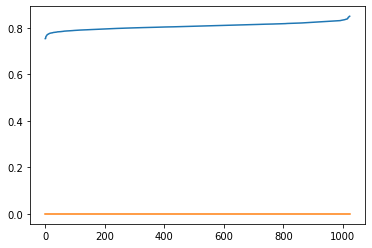

In [62]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


def cosine_similarity(a, b):
	return np.dot(a, b) / np.linalg.norm(a) / np.linalg.norm(b)

def req_emb_similarity(req_emb, text_embs):
	return max(cosine_similarity(req_emb, text_emb) for text_emb in text_embs)


def find_poem(request, top_n=10, lim=0., search_task_mood_meta=0.5):
	req_emb = get_embs(request)[0]

	texts_datas = []

	for index, row in tqdm(df.iterrows()):
		text_sim = req_emb_similarity(req_emb, row['text_embedding'])
		req_sim = 0
		#req_sim = cosine_similarity(req_emb, row['metadata_embedding'])
		#score = text_sim * search_task_mood_meta + req_sim * (1-search_task_mood_meta)
		score = text_sim

		texts_datas.append({'poem': row['text'], 'metadata': {k: v for k, v in row.items() if k != 'text' and k != 'metadata_embedding' and k != 'text_embedding'}, 
							'score': score, 'text_sim': text_sim, 'req_sim': req_sim})
	
	#mean_req_sim = np.mean([x['req_sim'] for x in texts_datas])
	#texts_datas = [x for x in texts_datas if x['req_sim'] > mean_req_sim * 1]
	
	texts_datas.sort(key=lambda x: x['score'])

	plt.plot([x['text_sim'] for x in sorted(texts_datas, key=lambda x: x['score'])], label='text')
	plt.plot([x['req_sim'] for x in sorted(texts_datas, key=lambda x: x['score'])], label='req')

	return texts_datas[-top_n:][::-1]


#request = 'из окны видны грустные пожелтевшие деревья но все же это моя любимая романтика'
#request = 'научный энтузиазм и борение за оригинальную идею'
#request = 'поднять! сделать! решительность! я! восклецания'
#request = 'дыр бул щыл убеш щур скум вы со бу р л эз'
request = 'стихотворение, поэзия, поэт, творчество, искусство'
#request = 'стихотворение, поэзия, поэт, творчество, искусство, серебрянный век, Автор: Владимир Маяковский'
#request = 'Автор: Александр Крученых'
#request = 'снова я напиваюсь, объем: количество строк: 4'
#request = 'когда теряет равновесие твое сознание усталое, одиночество, автор: Иосиф Бродский'

finded = find_poem(request)

for d in finded:
	print(d['poem'])
	print({k: v for k, v in d.items() if k != 'poem'})
	print('------')